# Neural Network Evaluation
Now we  want to test that our methodology is working well. The best way to do this is to see how our neural network selection works on a similar decay. In this case via a $J/\psi$.

In [59]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
plt.style.use([hep.style.ROOT, hep.style.firamath])

In [60]:
version = '0.0.3'
train = pd.read_csv(f'../data_files/{version}/all.csv', index_col=[0])
X_train = train.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_train = train.category

val = pd.read_csv(f'../data_files/{version}/val.csv', index_col=[0])
X_val = val.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_val = val.category

test = pd.read_csv(f'../data_files/{version}/test.csv', index_col=[0])
X_test = test.drop(['category', 'Lb_M', 'IsSimulated'], axis=1)
y_test = test.category

all = pd.read_csv(f'../data_files/{version}/all.csv', index_col=[0])
raw = pd.read_csv('../data_files/0.0.1/all.csv', index_col=[0])

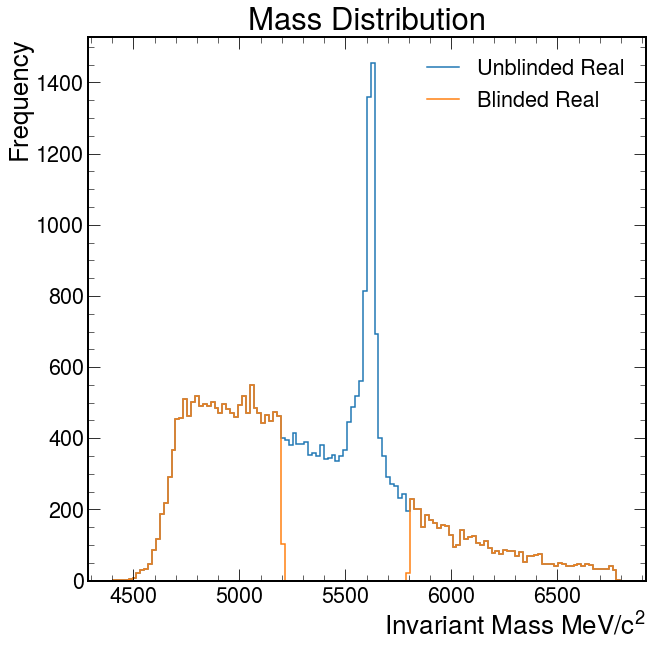

In [71]:
h1, bins = np.histogram(raw['Lb_M'][raw['IsSimulated']==False], bins=130)
h, _ = np.histogram(all['Lb_M'][all['IsSimulated']==False], bins=bins)

fig, ax = plt.subplots(1, 1)
hep.histplot([h1, h], bins=bins, ax=ax, label=['Unblinded Real', 'Blinded Real'])
plt.ylabel('Frequency')
plt.xlabel(r'Invariant Mass $MeV/c^2$')
plt.title('Mass Distribution')
plt.savefig('../images/Normalisation/RealData_Before_And_After_Reblind.png')
plt.legend()
plt.show()

## Evaluate without Re-Training ~ BROKEN AND BUGGY

In [72]:
orig_model = tf.keras.models.load_model('../neural_network/models/v7.0.2')
orig_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2

In [74]:
all_nosim = raw[raw['IsSimulated'] == False].copy()
preds = orig_model.predict(all_nosim.drop(['Lb_M', 'IsSimulated', 'category'], axis=1)).flatten()
all_nosim['PredictedClass'] = np.where(preds > 0.8, 1, 0)
# Generate predictions on all the raw data, with unequal events, cannot be used for training

# it predicts '1' for every single category which is odd!

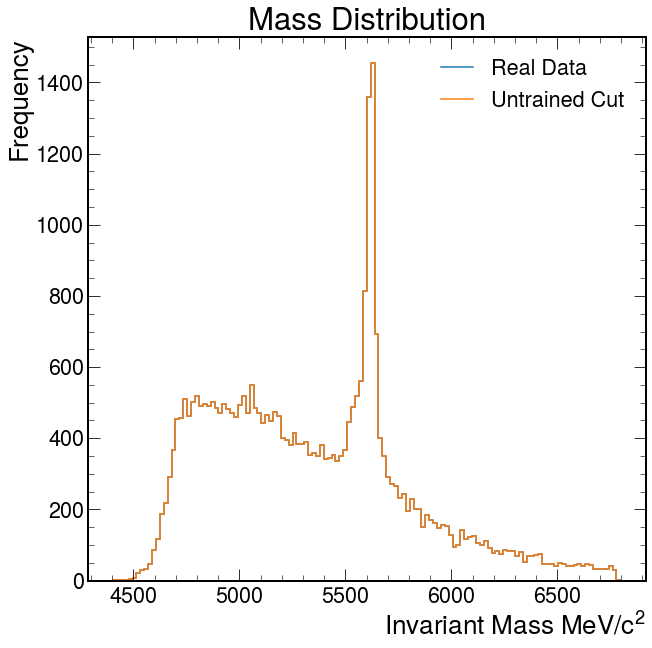

In [48]:

h, j = np.histogram(all_nosim['Lb_M'], bins=130)
h1, _ = np.histogram(all_nosim['Lb_M'][all_nosim['PredictedClass']==1], bins=j)

fig, ax = plt.subplots(1, 1)
hep.histplot([h, h1], j, ax=ax, label=['Real Data', 'Untrained Cut'])
plt.ylabel('Frequency')
plt.xlabel(r'Invariant Mass $MeV/c^2$')
plt.title('Mass Distribution')
plt.savefig('../images/Normalisation/Untrained_Full_Cut.png')
plt.legend()
plt.show()

In [79]:
#pred_train = orig_model.predict(X_train).flatten()
#train_classes_predicted = np.where(pred_train > 0.5, 1, 0)
#train_purity = np.count_nonzero(np.logical_and(train_classes_predicted, y_train))/np.unique(train_classes_predicted, return_counts=True)[1][1]
#accuracy_score(y_train, np.where(pred_train>0.5,1,0)), roc_auc_score(y_train, pred_train), train_purity

In [80]:
#roc = roc_curve(y_train, pred_train)
#fig, ax = plt.subplots(1, 1)
#ax.plot(roc[1], 1-roc[0], label='Train')
#ax.set_xlim(0.5, 1)
#ax.set_ylim(0.5, 1)
#plt.ylabel('Frequency')
#plt.xlabel('Probability')
#plt.legend()
#plt.show()

## Evaluate with Retraining ~ 50%

In [82]:
from tensorflow.keras import callbacks

custom_callbacks = [
    #callbacks.EarlyStopping(patience=40, min_delta=0.0005, restore_best_weights=True), 
    callbacks.ReduceLROnPlateau(patience=15, factor=0.2, min_lr=0.001)
    ]

model = tf.keras.models.load_model('../neural_network/models/v7.0.2')
history = model.fit(X_train, y_train, epochs=200, batch_size=512, validation_data=(X_val, y_val), callbacks=custom_callbacks, verbose=1)

Epoch 1/200
76/76 [==============================] - 5s 29ms/step - loss: 0.6957 - binary_accuracy: 0.5923 - auc: 0.6363 - true_positives: 10973.0000 - true_negatives: 11927.0000 - false_positives: 7406.0000 - false_negatives: 8360.0000 - val_loss: 0.6839 - val_binary_accuracy: 0.6654 - val_auc: 0.7790 - val_true_positives: 3246.0000 - val_true_negatives: 1900.0000 - val_false_positives: 1964.0000 - val_false_negatives: 624.0000
Epoch 2/200
76/76 [==============================] - 1s 14ms/step - loss: 0.6685 - binary_accuracy: 0.6025 - auc: 0.6500 - true_positives: 10742.0000 - true_negatives: 12556.0000 - false_positives: 6777.0000 - false_negatives: 8591.0000 - val_loss: 0.7075 - val_binary_accuracy: 0.4996 - val_auc: 0.4291 - val_true_positives: 0.0000e+00 - val_true_negatives: 3864.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 3870.0000
Epoch 3/200
76/76 [==============================] - 1s 16ms/step - loss: 0.6665 - binary_accuracy: 0.5988 - auc: 0.6480 - true_pos

## From Scratch

In [83]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.regularizers import l1_l2

model = Sequential([
        layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])
history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_val, y_val), callbacks=custom_callbacks, verbose=1)

Epoch 1/100
76/76 [==============================] - 3s 18ms/step - loss: 1.1042 - binary_accuracy: 0.6272 - auc: 0.6657 - val_loss: 1.0689 - val_binary_accuracy: 0.4983 - val_auc: 0.6733
Epoch 2/100
76/76 [==============================] - 1s 12ms/step - loss: 0.9615 - binary_accuracy: 0.6557 - auc: 0.7006 - val_loss: 0.9887 - val_binary_accuracy: 0.4995 - val_auc: 0.5582
Epoch 3/100
76/76 [==============================] - 1s 13ms/step - loss: 0.8620 - binary_accuracy: 0.6630 - auc: 0.7196 - val_loss: 0.9297 - val_binary_accuracy: 0.4996 - val_auc: 0.5572
Epoch 4/100
76/76 [==============================] - 1s 10ms/step - loss: 0.7572 - binary_accuracy: 0.6999 - auc: 0.7702 - val_loss: 0.8967 - val_binary_accuracy: 0.4996 - val_auc: 0.6412
Epoch 5/100
76/76 [==============================] - 1s 12ms/step - loss: 0.6933 - binary_accuracy: 0.7157 - auc: 0.7931 - val_loss: 0.8388 - val_binary_accuracy: 0.4996 - val_auc: 0.8287
Epoch 6/100
76/76 [==============================] - 1s 13ms

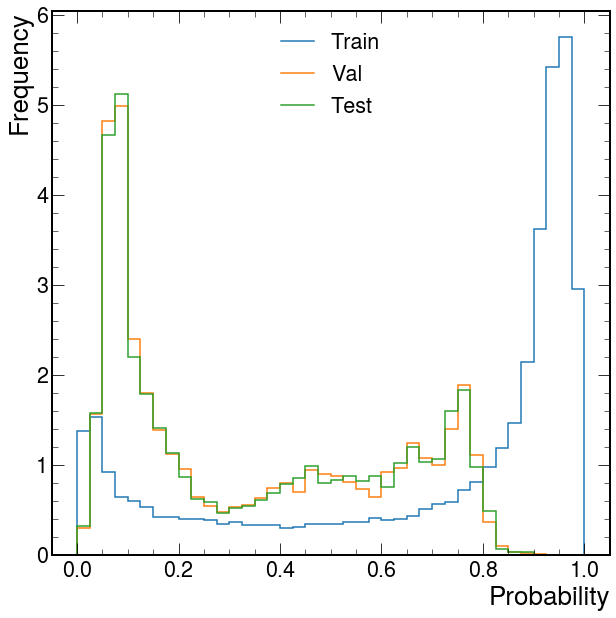

In [86]:
pbins = np.linspace(0, 1, 41)
h, pbins = np.histogram(model.predict(X_train).flatten(), pbins, density=True)
h1, _ = np.histogram(model.predict(X_val).flatten(), pbins, density=True)
h2, _ = np.histogram(model.predict(X_test).flatten(), pbins, density=True)

fig, ax = plt.subplots(1, 1)
hep.histplot([h, h1, h2], pbins, ax=ax, label=['Train', 'Val', 'Test'], stack=False)
plt.ylabel('Frequency')
plt.xlabel('Probability')
plt.legend(loc='upper center')
plt.show()